# PySpark Setup

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!cp drive/MyDrive/MMDS-data/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Task2').getOrCreate()

# Main

## Required Libraries

In [ ]:
!pip install -q pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.functions import array_to_vector
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType
from pyspark.sql import Window
from pyclustering.cluster.cure import cure
import matplotlib.pyplot as plt

## Read data

In [ ]:
data_path = 'embeddings.csv'
df = spark.read \
          .csv(data_path, header=True, inferSchema=True)

## CURE

In [ ]:
class CURE:
  def __init__(self, dataframe):
    self.df = dataframe
    self.df_sample = self.df.sample(fraction=0.5) # Random sampling
    self.num_representative = None
    self.result = None

  # Convert 'embedding' column from string type to Vectors type
  def vectorize(self, dataframe):
    return dataframe.select(F.split(self.df['embedding'], ',') \
                    .cast('array<double>').alias('embeddings')) \
                    .select(array_to_vector('embeddings').alias('embeddings'))

  # Convert 'embedding' column from string type into a list of arrays
  def to_list(self, dataframe):
    return list(dataframe.select(F.split(self.df['embedding'], ',') \
                          .cast('array<double>').alias('embeddings')) \
                          .agg(F.collect_list('embeddings').alias('embeddings')) \
                          .select('embeddings') \
                          .toPandas()['embeddings'])[0]

  def pass_1(self, dataframe, num_representative):
    # Make use of 'cure' library to apply hierarchical agglomerative algorithm
    # on sample dataframe and retrieve representatives of each cluster
    cure_instance = cure(self.to_list(dataframe),
                         number_cluster=2,
                         number_represent_points=num_representative,
                         compression=0.2)
    cure_instance.process()
    representors = cure_instance.get_representors()

    # Create dataframe of representatives and their respective cluster IDs
    data = []
    for cluster_id, reps in enumerate(representors):
      for rep in reps:
        data.append(Row(cluster_id=cluster_id, representative=Vectors.dense(rep)))

    return spark.createDataFrame(data)

  def pass_2(self, dataframe):
    def euclidean_distance(v1, v2):
      return float(Vectors.squared_distance(v1, v2)) ** 0.5
    distance_udf = F.udf(euclidean_distance, DoubleType())

    # Define a window specification to rank distances for each embedding.
    # The window is partitioned by 'embeddings', meaning that each unique embedding
    # is treated separately for the ranking process. Within each partition,
    # the rows are ordered by 'distance' in ascending order.
    # This allows the smallest distance for each embedding to receive the highest rank (1).
    window_spec = Window.partitionBy('embeddings').orderBy('distance')

    return self.vectorize(self.df) \
                .crossJoin(dataframe) \
                .withColumn('distance', distance_udf(F.col('embeddings'), F.col('representative'))) \
                .withColumn('rank', F.row_number().over(window_spec)) \
                .filter(F.col('rank') == 1) \
                .select('embeddings', 'cluster_id', 'distance')

  # Compute average distance from data points
  # to the nearest representative of the cluster for each cluster
  def get_average_distance(self, dataframe):
    return dataframe.groupBy('cluster_id') \
                    .agg(F.avg('distance').alias('avg_distance'))

  # Main method to run CURE algorithm
  def run_cure(self, num_representative):
    self.num_representative = num_representative
    df_pass_1 = self.pass_1(self.df_sample, self.num_representative)
    df_pass_2 = self.pass_2(df_pass_1)
    self.result = df_pass_2

  # Plot bar chart of the average distance from data points
  # to the nearest representative of the cluster for each cluster
  def visualize(self):
    res = self.get_average_distance(self.result) \
              .toPandas()

    fig = plt.figure(figsize=(6, 4))
    bars = plt.bar(res['cluster_id'], res['avg_distance'])
    plt.title(f'With num_representative={self.num_representative}', fontweight='bold', fontsize=15)
    plt.xlabel('Cluster ID', fontsize=10)
    plt.ylabel('Average Distance', fontsize=10)
    plt.xticks(res['cluster_id'].astype(int))

    # Write the result above each bar
    for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    plt.show()

  # Get the result dataframe of CURE algorithm after executing run_cure method
  def get_result(self):
    return self.result

## Experiment

In [ ]:
def run_experiment(dataframe):
  c = CURE(dataframe)
  for num_representative in range(3, 9):
    c.run_cure(num_representative)
    c.visualize()

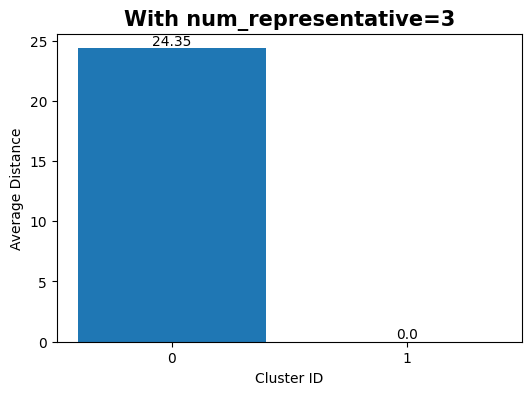

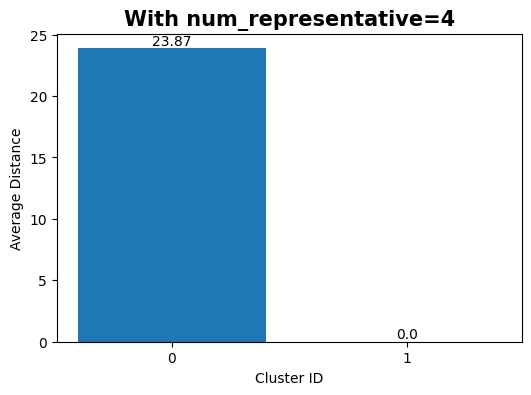

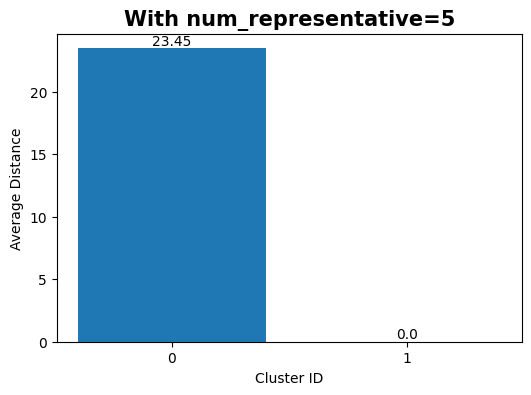

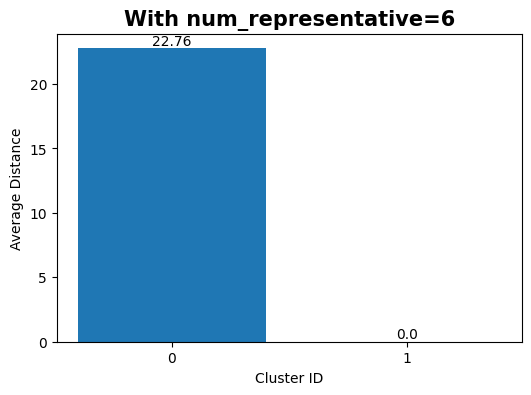

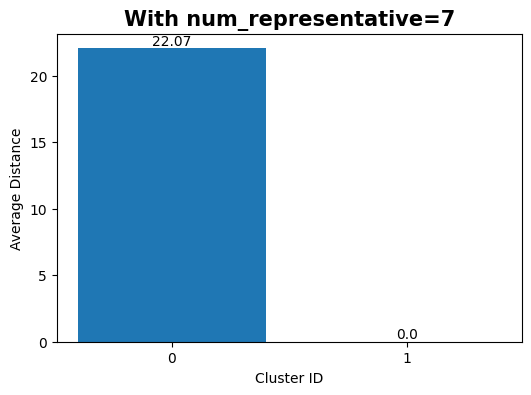

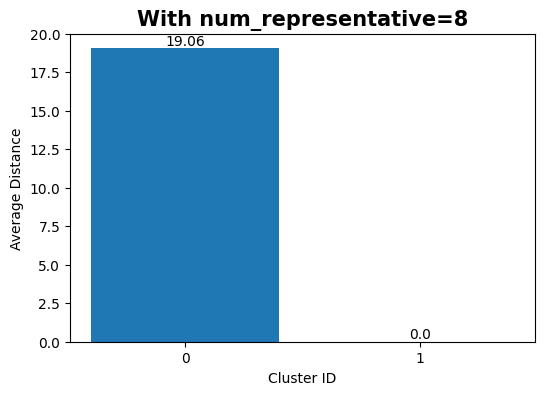

In [ ]:
run_experiment(df)